# Task 3

## Imports

In [258]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import ultralytics
import os
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import cv2
from IPython.display import Image
from ultralytics import YOLO
import pickle
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, Image
import os
import json
import sys

ultralytics.checks()


Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Core(TM) i7-10510U 1.80GHz)
Setup complete ✅ (8 CPUs, 15.4 GB RAM, 524.8/620.0 GB disk)


## Defining functions

In [259]:
def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.png', image)[1].tobytes()
    display(Image(data=img_bytes))
    
def loadImage(num, imgLoadSizeRatio = 1, dataDir = 'data/imgs', standardSize = -1):
    img = cv2.imread(os.path.join(dataDir, f'{num}'))
    if standardSize > 0:
        img = cv2.resize(img, (standardSize, standardSize))
    elif imgLoadSizeRatio != 1:
        img = cv2.resize(img, (0, 0), fx = imgLoadSizeRatio, fy = imgLoadSizeRatio)
    return img

def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names
    
def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    results = yolo(image_url, conf=conf, iou=iou, verbose=False)
    img = cv2.cvtColor(results[0].plot()[:, :, [2,1,0]], cv2.COLOR_BGR2RGB)
    bounding_boxes = results[0].boxes.xyxy.tolist()
    return bounding_boxes

def drawBB(img, bbs):
    img = img.copy()
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

def getBBImages(image, bbs):
    bb_imgs = []
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        cropped = image[y1:y2, x1:x2]
        bb_imgs.append(cropped)
    return bb_imgs
        
def getGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask 

def maskLego(lego_img):
    bbColorBlurQnt = 31
    bbColorClusterSize = 10
    
    # Apply K-means clustering to reduce the number of colors
    try:
        pixels = lego_img.reshape((-1, 3))
        kmeans_all = KMeans(n_clusters=bbColorClusterSize, n_init=20, max_iter=100, tol=1e-4, random_state=0)
        kmeans_all.fit(pixels)
        lego_img_kmeans = kmeans_all.cluster_centers_[kmeans_all.labels_].reshape(lego_img.shape).astype(np.uint8)
        lego_img = lego_img_kmeans
    except:
        print("Failed to reduce the color space for lego color extraction")
        
    fg_mask = getGrabCutMask(lego_img)
    
    # Apply a blur to the image to reduce noise
    lego_img_blurred = cv2.GaussianBlur(lego_img, (bbColorBlurQnt, bbColorBlurQnt), 0)
    
    # Masked image
    masked = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
    return masked, fg_mask

In [260]:
# Create folder to save the results
try:
    folder_name = "results"
    os.mkdir(folder_name)
except FileExistsError:
    pass

## Load YOLO model

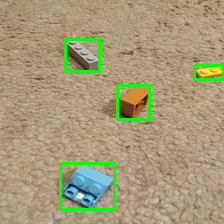

In [261]:
test_image = 'datasets/images/valid/4_1.jpg'
yolo = YOLO('yolov8s.pt')

bbs = run_yolo(yolo, test_image)
img = loadImage('4_1.jpg')
img_bb = drawBB(img, bbs)
render(img_bb)

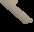

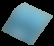

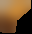

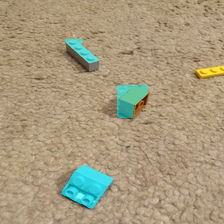

In [262]:
bb_imgs = getBBImages(img, bbs)
masks = []

for box in bb_imgs:
    img_lego, mask = maskLego(box)
    masks.append(mask)
    render(img_lego)


img_neon = img.copy()

for mask, bb in zip(masks, bbs):
    x1, y1, x2, y2 = [int(x) for x in bb]
    
    # Apply the neon effect to the bounding box
    for y in range(y1, y2):
        for x in range(x1, x2):
            if mask[y - y1, x - x1]:
                neon = (img_neon[y, x] + [255, 255, 0] ) / 2
                img_neon[y, x] = np.uint8(neon)
    
# Display the image with the neon bounding box
render(img_neon)
